In [1]:
from IPython.display import display, Math, Markdown

from math import *
import numpy as np
import pandas as pd
import scipy.stats
from scipy.optimize import curve_fit
from scipy.optimize import bisect

import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = "dotted"
plt.rcParams["errorbar.capsize"] = 2
plt.rcParams["savefig.dpi"] = 200
# plt.rcParams["savefig.bbox"] = "tight"
# plt.rcParams["savefig.pad_inches"] = 0.01
plt.rcParams["savefig.format"] = "pdf"

from uncertainties import unumpy as unp
from uncertainties import ufloat
from uncertainties.unumpy import uarray
from uncertainties.unumpy import nominal_values as unominal
from uncertainties.unumpy import std_devs as ustdev

def display_ufloat(uf, var=None, dim=None):
    res = ''
    if var is not None:
        res += var + '='
    res += f"{uf:L}"
    if dim is not None:
        res += ' \\ ' + dim
    display(Math(res))

## Резонанс токов в параллельном контуре

**Цель работы:** исследование резонанса токов в параллельном колебательном контуре с изменяемой ёмкостью, включающее получение амплитудно-частотных и фазово-частотных характеристик, а также определение основных параметров контура.

**В работе используются:** генератор сигналов, источник тока, нагруженный на параллельный колебательный контур с переменной ёмкостью, двулучевой осциллограф, цифровые вольтметры.


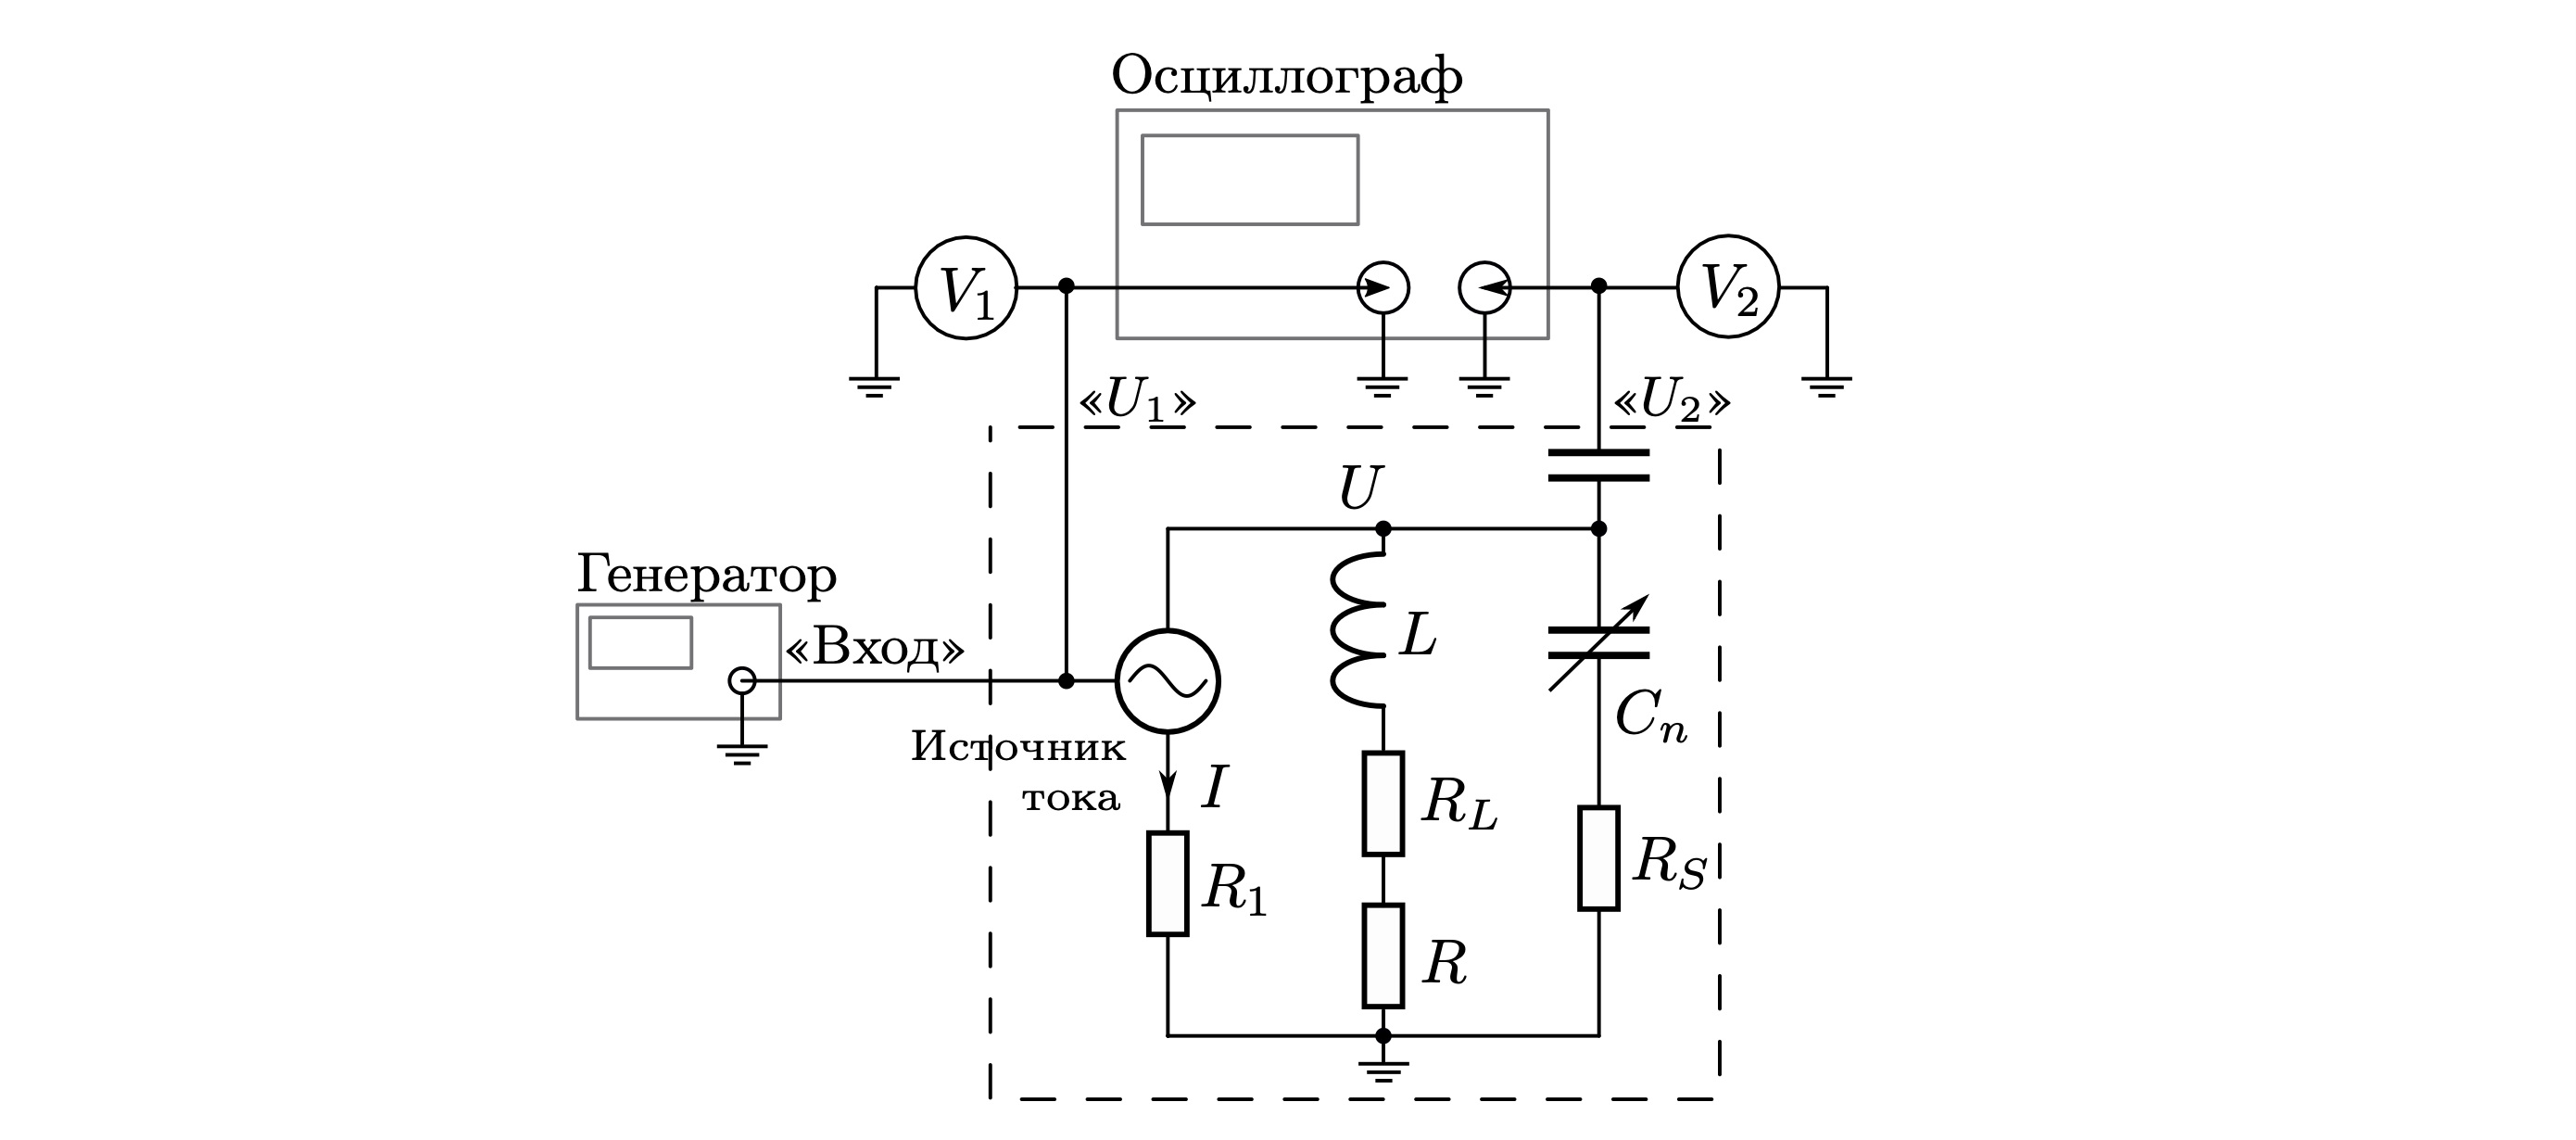

# I. Измерения

In [2]:
df = pd.DataFrame(columns=["C", "f", "U", "E", "L", "rho", "Z", "Q", "R_Sigma", "R_S_max", "R_L"], index=range(1, 8))

In [3]:
df["C"] = uarray([25.1, 33.2, 47.3, 57.4, 67.5, 82.7, 101.6], 0.1) * 1e-9  # Ф
R = ufloat(3.50, 0.01)  # Ом
R1 = ufloat(1008, 1)  # Ом

#### 8

In [4]:
df["E"] = uarray([377, 373, 369, 367, 366, 363, 363], 1) * 1e-4  # В
df["U"] = uarray([2159, 1674, 1210, 1033, 870, 701, 611], 1) * 1e-4  # В
df["f"] = uarray([32.16, 27.86, 23.23, 21.29, 19.49, 17.72, 16.06], 0.01) * 1e3  # Гц

#### 9

In [5]:
get_range = lambda f0, f1, f2, n: np.round(np.concatenate([np.linspace(f1, f0, n), np.linspace(f0, f2, n)[1:]]), 2)

In [6]:
C2_9 = df["C"][2]
f2_9 = uarray(get_range(27.86, 27.18, 28.53, 9), 0.01) * 1e3  # Гц
U2_9 = uarray([1009, 1091, 1192, 1304, 1407, 1505, 1599, 1660, 1673, 1646, 1574, 1487, 1377, 1279, 1185, 1087, 1009], 1) * 1e-4  # В

In [7]:
C6_9 = df["C"][6]
f6_9 = uarray(get_range(17.72, 17.08, 18.39, 9), 0.01) * 1e3  # Гц
U6_9 = uarray([424, 460, 499, 541, 585, 629, 666, 692, 702, 695, 667, 630, 583, 540, 499, 458, 425], 1) * 1e-4  # В

#### 10

In [8]:
timediv = 1e-6  # с/дел
f2_10 = uarray(get_range(27.86, 26.26, 29.54, 9), 0.01) * 1e3  # Гц
t2_10 = uarray([2.5, 2.4, 2.2, 2.0, 1.9, 1.6, 1.2, 0.7, 0, -0.7, -1.2, -1.5, -1.8, -1.9, -2.0, -2.1, -2.2], 0.1) * timediv  # с
phi2_10 = 2 * np.pi * t2_10 * df["f"][2]

In [9]:
timediv = 1e-6  # с/дел
f6_10 = uarray(get_range(17.72, 16.17, 19.43, 9), 0.01) * 1e3  # Гц
t6_10 = uarray([2.0, 1.8, 1.7, 1.6, 1.5, 1.3, 1.0, 0.5, 0, -0.5, -1.0, -1.2, -1.4, -1.5, -1.6, -1.7, -1.8], 0.1) * timediv  # с
phi6_10 = 2 * np.pi * t6_10 * df["f"][6]

# II. Обработка результатов

#### 11 **Результаты измерений**

In [10]:

omega0 = 2 * np.pi * df["f"]
df["L"] = 1 / (omega0 ** 2 * df["C"])

df["rho"] = (df["L"] / df["C"]) ** 0.5

# (13)
I = df["E"] / R1
df["Z"] = df["U"] / I

# (14)
df["Q"] = df["Z"] / df["rho"]

# (14)
# df["R_Sigma"] = df["Z"] / df["Q"] ** 2
df["R_Sigma"] = df["rho"] / df["Q"]

df["R_S_max"] = 1e-3 * df["rho"]

df["R_L"] = df["R_Sigma"] - df["R_S_max"] - R

L_mean = ufloat(np.mean(unominal(df["L"])), np.std(unominal(df["L"])))
R_L_mean = ufloat(np.mean(unominal(df["R_L"])), np.std(unominal(df["R_L"])))

In [11]:

table = df.copy()

def apply_format(df, column, coefficient, precision):
    df[column] = df[column].apply(
        lambda x: f"${x * coefficient:.{precision}fL}$"
    )

apply_format(table, "C", 1e9, 1)
apply_format(table, "f", 1e-3, 2)
apply_format(table, "U", 1e3, 1)
apply_format(table, "E", 1e3, 1)
apply_format(table, "L", 1e6, 1)
apply_format(table, "rho", 1, 1)
apply_format(table, "Z", 1, 0)
apply_format(table, "Q", 1, 2)
apply_format(table, "R_Sigma", 1, 2)
apply_format(table, "R_S_max", 1, 4)
apply_format(table, "R_L", 1, 2)

headers = ["$C, нФ$", "$f, кГц$", "$U, мВ$", "$\mathcal{E}, мВ$", "$L, мкГн$", r"$\rho, Ом$", "$\|Z_{рез}\|, Ом$", "$Q$", "$R_\Sigma, Ом$", r"$R_S^\text{max}, Ом$", "$R_L, Ом$"]
display(Markdown(table.to_markdown(headers=headers, index=True)))

display_ufloat(L_mean * 1e6, "L_{ср}", "мкГн")
display_ufloat(R_L_mean, "{R_L}_{ср}", "Ом")

|    | $C, нФ$         | $f, кГц$         | $U, мВ$         | $\mathcal{E}, мВ$   | $L, мкГн$       | $\rho, Ом$      | $\|Z_{рез}\|, Ом$   | $Q$              | $R_\Sigma, Ом$   | $R_S^\text{max}, Ом$   | $R_L, Ом$       |
|---:|:----------------|:-----------------|:----------------|:--------------------|:----------------|:----------------|:--------------------|:-----------------|:-----------------|:-----------------------|:----------------|
|  1 | $25.1 \pm 0.1$  | $32.16 \pm 0.01$ | $215.9 \pm 0.1$ | $37.7 \pm 0.1$      | $975.7 \pm 3.9$ | $197.2 \pm 0.8$ | $5773 \pm 17$       | $29.28 \pm 0.14$ | $6.73 \pm 0.06$  | $0.1972 \pm 0.0008$    | $3.04 \pm 0.06$ |
|  2 | $33.2 \pm 0.1$  | $27.86 \pm 0.01$ | $167.4 \pm 0.1$ | $37.3 \pm 0.1$      | $983.0 \pm 3.0$ | $172.1 \pm 0.5$ | $4524 \pm 13$       | $26.29 \pm 0.11$ | $6.54 \pm 0.04$  | $0.1721 \pm 0.0005$    | $2.87 \pm 0.04$ |
|  3 | $47.3 \pm 0.1$  | $23.23 \pm 0.01$ | $121.0 \pm 0.1$ | $36.9 \pm 0.1$      | $992.4 \pm 2.3$ | $144.8 \pm 0.3$ | $3305 \pm 10$       | $22.82 \pm 0.08$ | $6.35 \pm 0.03$  | $0.1448 \pm 0.0003$    | $2.70 \pm 0.03$ |
|  4 | $57.4 \pm 0.1$  | $21.29 \pm 0.01$ | $103.3 \pm 0.1$ | $36.7 \pm 0.1$      | $973.6 \pm 1.9$ | $130.2 \pm 0.2$ | $2837 \pm 9$        | $21.79 \pm 0.08$ | $5.98 \pm 0.03$  | $0.1302 \pm 0.0002$    | $2.35 \pm 0.03$ |
|  5 | $67.5 \pm 0.1$  | $19.49 \pm 0.01$ | $87.0 \pm 0.1$  | $36.6 \pm 0.1$      | $987.9 \pm 1.8$ | $121.0 \pm 0.2$ | $2396 \pm 7$        | $19.81 \pm 0.07$ | $6.11 \pm 0.03$  | $0.1210 \pm 0.0002$    | $2.49 \pm 0.03$ |
|  6 | $82.7 \pm 0.1$  | $17.72 \pm 0.01$ | $70.1 \pm 0.1$  | $36.3 \pm 0.1$      | $975.5 \pm 1.6$ | $108.6 \pm 0.1$ | $1947 \pm 6$        | $17.92 \pm 0.06$ | $6.06 \pm 0.03$  | $0.1086 \pm 0.0001$    | $2.45 \pm 0.03$ |
|  7 | $101.6 \pm 0.1$ | $16.06 \pm 0.01$ | $61.1 \pm 0.1$  | $36.3 \pm 0.1$      | $966.6 \pm 1.5$ | $97.5 \pm 0.1$  | $1697 \pm 6$        | $17.39 \pm 0.06$ | $5.61 \pm 0.02$  | $0.0975 \pm 0.0001$    | $2.01 \pm 0.02$ |

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#### 12 **Амплитудно-частотные характеристики**

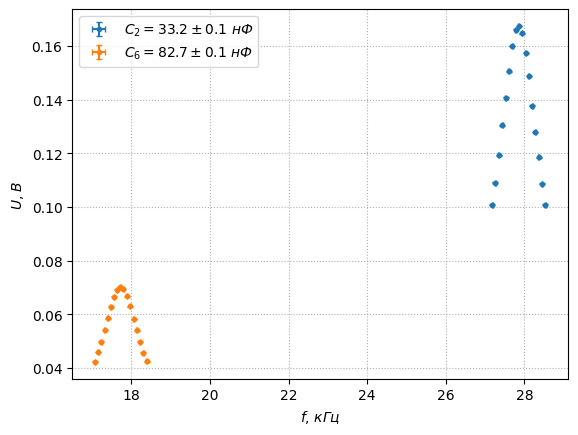

In [12]:

plt.xlabel(r"$f$, $кГц$")
plt.ylabel(r"$U$, $В$")

X = f2_9 / 1e3
Y = U2_9
plt.errorbar(unominal(X), unominal(Y), xerr=ustdev(X), yerr=ustdev(Y), fmt=".", label=f"$C_2 = {C2_9 * 1e9:.3L} \ нФ$")

X = f6_9 / 1e3
Y = U6_9
plt.errorbar(unominal(X), unominal(Y), xerr=ustdev(X), yerr=ustdev(Y), fmt=".", label=f"$C_6 = {C6_9 * 1e9:.3L} \ нФ$")

plt.legend()
plt.show()

#### 13 **Амплитудно-частотные характеристики в безразмерных координатах**

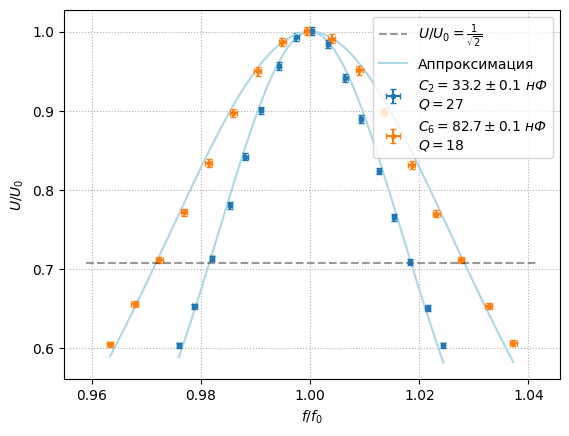

In [13]:

plt.xlabel(r"$f/f_0$")
plt.ylabel(r"$U/U_0$")

def handle(f, U, label):

    def lorentzian(x, x0, a, gamma):
        return a / (1 + ((x - x0) / gamma) ** 2)

    x = unominal(f)
    y = unominal(U)
    bounds = ([x.min(), y.max() / 1.001, -np.inf], [x.max(), y.max() * 1.001, np.inf])
    popt, pcov = curve_fit(lorentzian, x, y, bounds=bounds)
    perr = np.sqrt(np.diag(pcov))
    
    f0, U0, gamma = uarray(popt, perr)
    func = lambda x: lorentzian(x * f0, f0, U0, gamma) / U0
    X = f / f0
    Y = U / U0
    x_min, x_max = unominal(X).min(), unominal(X).max()
    delta = bisect(lambda x: (func(x) - 2 ** -0.5).nominal_value, 1, x_max) - bisect(lambda x: (func(x) - 2 ** -0.5).nominal_value, 0.95, 1)
    Q = 1 / delta

    x_plt = np.linspace(x_min, x_max, 100)
    plt.plot(x_plt, unominal(func(x_plt)), color="lightblue")
    plt.errorbar(unominal(X), unominal(Y), xerr=ustdev(X), yerr=ustdev(Y), fmt=".", label=label + f"\n$Q = {Q:.0f}$")


handle(f2_9, U2_9, label=f"$C_2 = {C2_9 * 1e9:.3L} \ нФ$")
handle(f6_9, U6_9, label=f"$C_6 = {C6_9 * 1e9:.3L} \ нФ$")
plt.plot(plt.gca().get_xlim(), [2 ** -0.5] * 2, label=r"$U/U_0 = \frac{1}{\sqrt{2}}$", linestyle="--", color="black", alpha=0.4)
plt.plot([], [], color="lightblue", label="Аппроксимация")

plt.legend(loc=1)
plt.show()

#### 14 **Фазово-частотные характеристики**

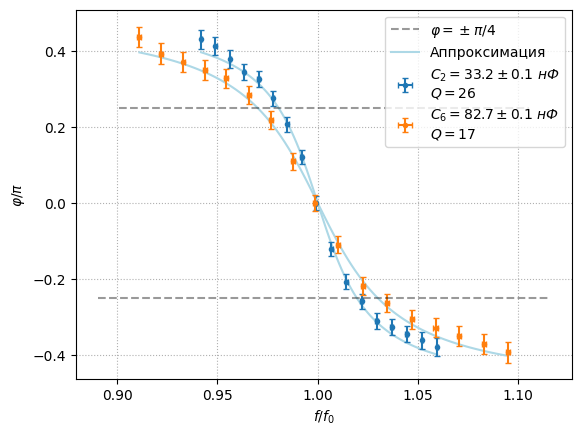

In [14]:

plt.xlabel(r"$f/f_0$")
plt.ylabel(r"$\varphi/\pi$")

def handle(f, phi, label):
    nX = unominal(f) / 1e3
    nY = unominal(phi)

    func0 = lambda x, x0, a, b: a * np.arctan(b * (x - x0)) 
    bounds = ([nX.min(), nY.max() / (np.pi / 2) / 1.1, -4], [nX.max(), nY.max() / (np.pi / 2) * 1.4, 0])
    popt, pcov = curve_fit(func0, nX, nY, bounds=bounds)
    perr = np.sqrt(np.diag(pcov))

    # x_plot = np.linspace(nX.min(), nX.max(), 100)
    # plt.plot(x_plot, func(x_plot, *popt))
    
    f0, a, b = uarray(popt, perr)
    X = (f / 1e3) / f0
    Y = phi / a / np.pi
    func = lambda x: func0(x * f0.nominal_value, f0.nominal_value, a.nominal_value, b.nominal_value) / a / np.pi
    x_min, x_max = unominal(X).min(), unominal(X).max()
    delta = bisect(lambda x: (func(x).nominal_value - (-1/4)), 1, x_max) - bisect(lambda x: (func(x) - 1/4).nominal_value, x_min, 1)
    Q = 1 / delta

    x_plt = np.linspace(x_min, x_max, 100)
    plt.plot(x_plt, unominal(func(x_plt)), color="lightblue")
    plt.errorbar(unominal(X), unominal(Y), xerr=ustdev(X), yerr=ustdev(Y), fmt=".", label=label + f"\n$Q = {Q:.0f}$")


handle(f2_10, phi2_10, label=f"$C_2 = {C2_9 * 1e9:.3L} \ нФ$")
handle(f6_10, phi6_10, label=f"$C_6 = {C6_9 * 1e9:.3L} \ нФ$")
plt.plot(plt.gca().get_xlim(), [1/4] * 2, label=r"$\varphi = \pm \pi/4$", linestyle="--", color="black", alpha=0.4)
plt.plot(plt.gca().get_xlim(), [-1/4] * 2, linestyle="--", color="black", alpha=0.4)
plt.plot([], [], color="lightblue", label="Аппроксимация")

plt.legend(loc=1)
plt.show()

#### 15 **Среднее значение сопротивления катушки**

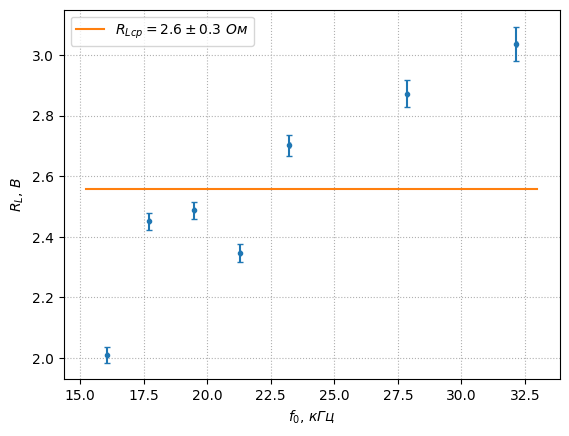

In [15]:

plt.xlabel(r"$f_0$, $кГц$")
plt.ylabel(r"$R_L$, $В$")

X = df["f"] / 1e3
Y = df["R_L"]
plt.errorbar(unominal(X), unominal(Y), xerr=ustdev(X), yerr=ustdev(Y), fmt=".")
plt.plot(plt.gca().get_xlim(), [R_L_mean.nominal_value] * 2, label=f"${{R_L}}_{{ср}} = {R_L_mean:.1fL}$ $Ом$")

plt.legend()
plt.show()

#### 16 **Векторная диаграмма**

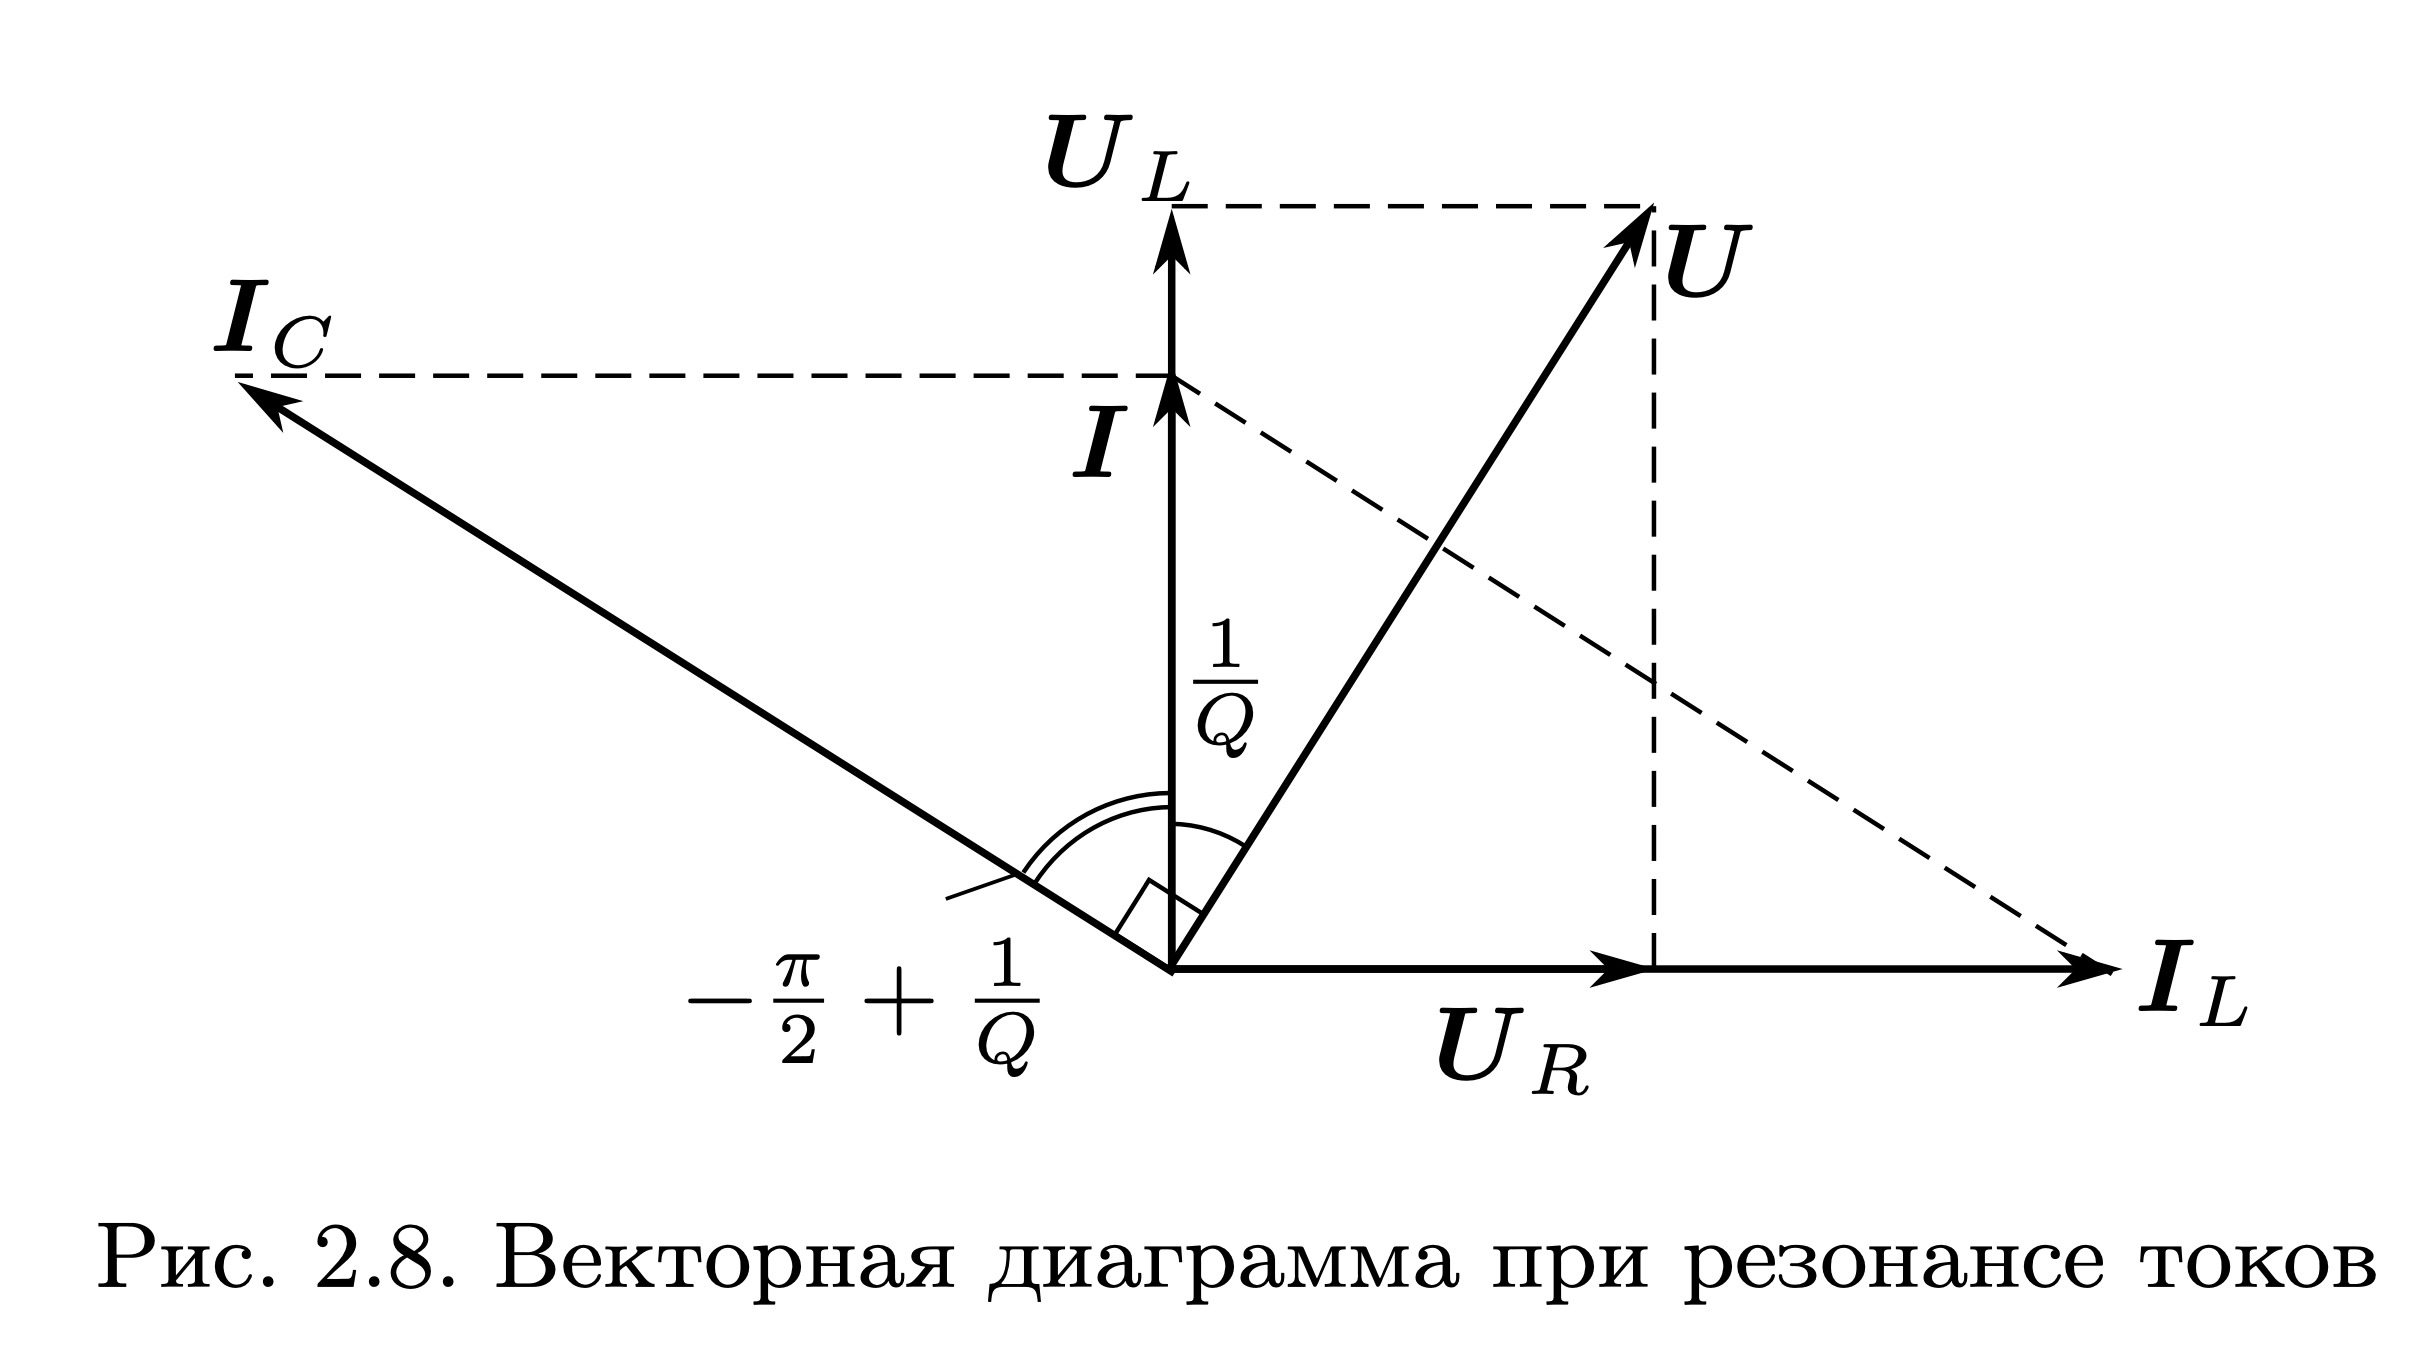